# Estimation of the pure camera rotation (no translation) between two consecutive frames

## Load data

In [1]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import scipy as sp
import json

In [2]:
def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
  ax[1].imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))

In [14]:
im1 = cv2.imread("frame1.png")
im2 = cv2.imread("frame2.png")

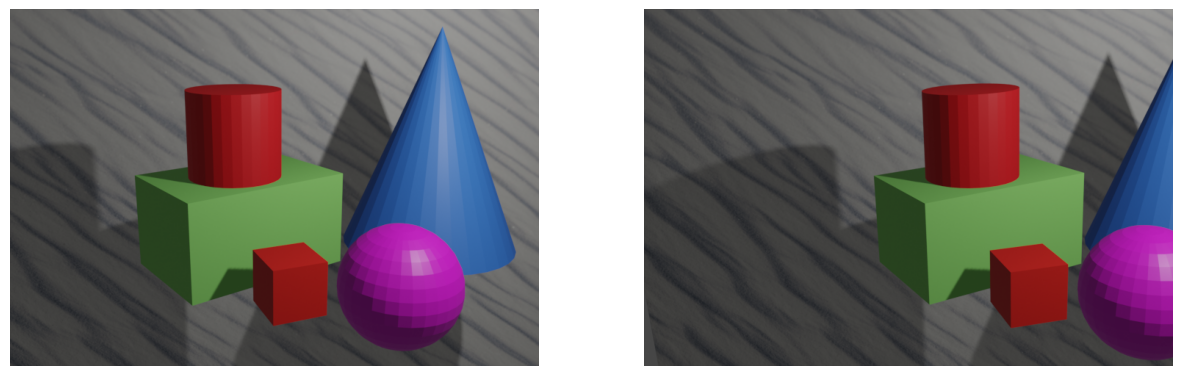

In [15]:
plot_imgs(im1, im2)

In [16]:
image_info = json.load(open("metaInfo.txt"))

In [17]:
image_info["cam"]

{'intrinsics': [[800.0, 0, 360.0], [0, 799.9996948242188, 243.0], [0, 0, 1]]}

In [18]:
# camera matrix
K = np.array(image_info["cam"]["intrinsics"])
K

array([[800.        ,   0.        , 360.        ],
       [  0.        , 799.99969482, 243.        ],
       [  0.        ,   0.        ,   1.        ]])

In [19]:
# true rotation matrix of the camera between two frames
R_true = np.array(image_info["transforms"]["rotation_matrix"])
R_true

array([[ 9.84807730e-01,  1.51808059e-08, -1.73648179e-01],
       [-1.51808059e-08,  1.00000000e+00,  1.32815359e-09],
       [ 1.73648179e-01,  1.32815359e-09,  9.84807730e-01]])

## Check correctness of intrinsics matrix by reprojecting points on the frame

In [20]:
# coordiantes of some vertices in the Blender's world frame
vertex1 = np.array([0.11, -1.85, 1])
vertex2 = np.array([-1.33, -2.62, 1.93])

Blender uses Passive transform convention in the form: qw = Rwc qc + t

In [21]:
Rwc = np.array(image_info["extrinsics"]["rotation_matrix"])
Twc = np.array(image_info["extrinsics"]["translation"])

Expressing vertices coordinates in the camera frame

In [22]:
v1_cam = np.linalg.inv(Rwc) @ (vertex1 - Twc)
v2_cam = np.linalg.inv(Rwc) @ (vertex2 - Twc)

Reprojecting 3D points in the camera frame using known camera model K back on the original image

In [23]:
res_proj, _= cv2.projectPoints(np.vstack((v1_cam, v2_cam)), np.eye(3), np.zeros((3,)), K, np.zeros((5, )))

In [24]:
np.round(res_proj).astype(np.int32).reshape(2,-1)

array([[358, 357],
       [242, 265]], dtype=int32)

In [25]:
im1_ = im1
for point in res_proj.reshape(2,-1):
  point = np.round(point).astype(np.int32)
  im1_ = cv2.circle(im1_, point, 5, (0,0,255), 2)

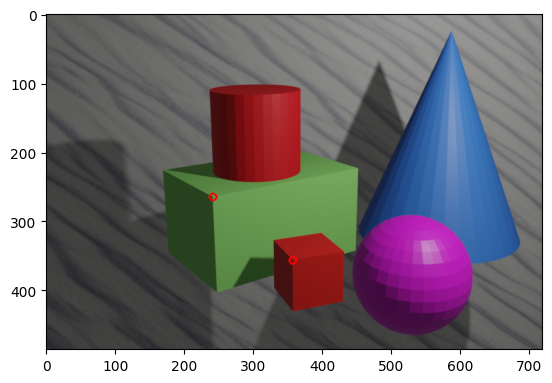

In [26]:
plt.imshow(cv2.cvtColor(im1_, cv2.COLOR_BGR2RGB))

## Detect features and its descriptors (SIFT)

In [27]:
sift = cv2.SIFT.create()

In [28]:
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

In [29]:
kp1, des1 = sift.detectAndCompute(im1_gray, None)
kp2, des2 = sift.detectAndCompute(im2_gray, None)

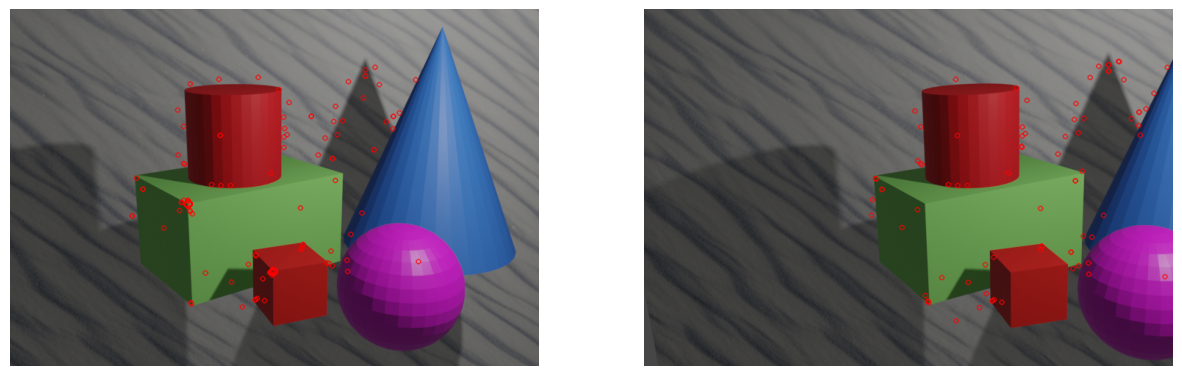

In [30]:
kp_img1 = cv2.drawKeypoints(im1, kp1, None, color=(0,0,255), flags=0)
kp_img2 = cv2.drawKeypoints(im2, kp2, None, color=(0,0,255), flags=0)
plot_imgs(kp_img1, kp_img2)

## Feature matching using ratio test

In [31]:
bf = cv2.BFMatcher() # brute force feature matcher
matches = bf.knnMatch(des1,des2,k=2) # find for each feature 2 closest according to euclidian distance

Ratio test is a ratio between euclidian distances from the source image point descriptor and two closest descriptors from target image point

In [32]:
# Apply ratio test
good_matches = []
thershold = 0.75
for m,n in matches:
    if m.distance < thershold*n.distance:
        good_matches.append([m])

In [33]:
matched_imgs = cv2.drawMatchesKnn(im1, kp1, im2, kp2, random.choices(good_matches, k=50),
                            outImg=None,
                            matchColor=(0, 0, 255),
                            singlePointColor=(0, 255, 255),
                            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

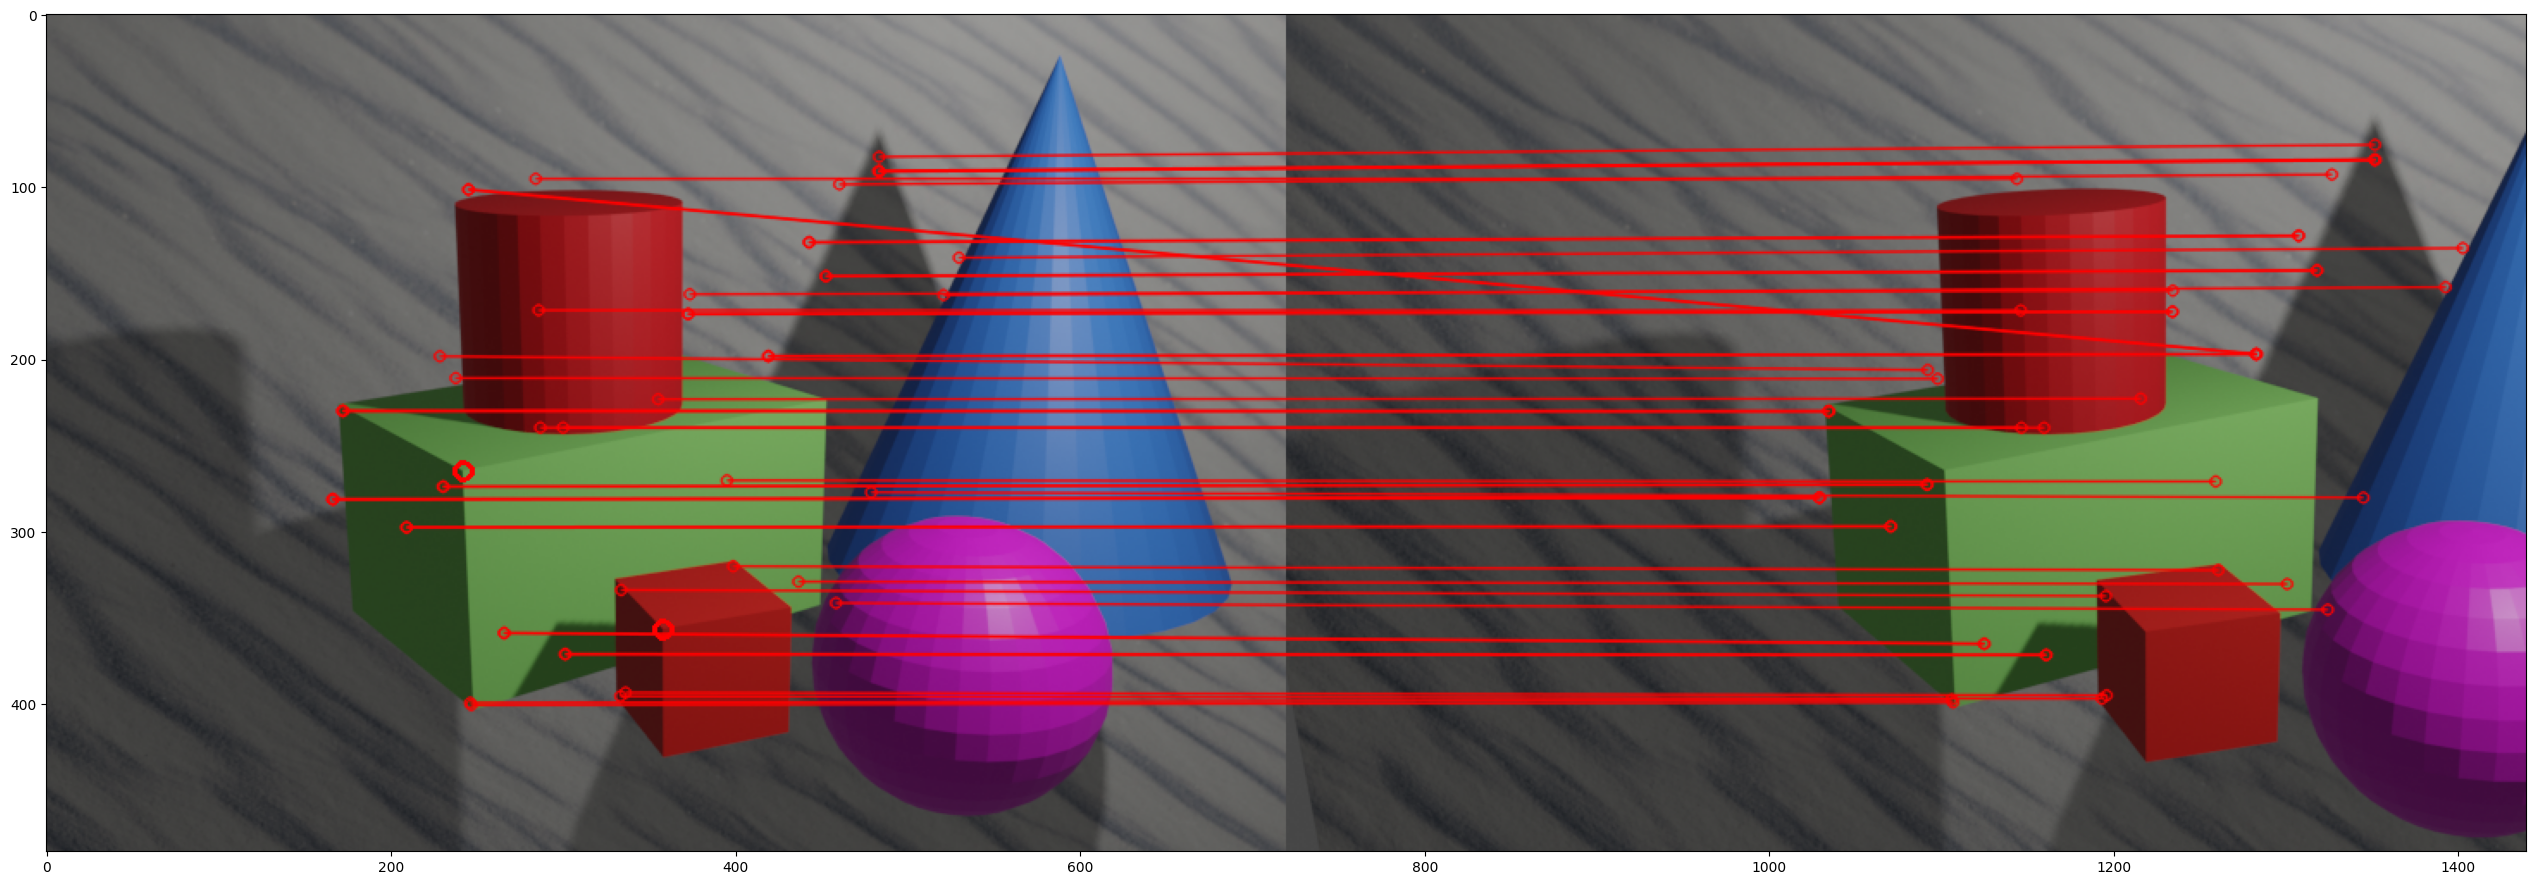

In [34]:
plt.figure(figsize = (32,64))
plt.imshow(cv2.cvtColor(matched_imgs, cv2.COLOR_BGR2RGB))

## Fitting Homography using well matched points

In [35]:
good_kp1_indx = []
good_kp2_indx = []
for m in good_matches:
  good_kp1_indx.append(m[0].queryIdx)
  good_kp2_indx.append(m[0].trainIdx)


In [36]:
good_kp1 = []
good_kp2 = []
for i,j in zip(good_kp1_indx, good_kp2_indx):
  good_kp1.append(kp1[i])
  good_kp2.append(kp2[j])

In [37]:
 H, status = cv2.findHomography(cv2.KeyPoint.convert(good_kp2), cv2.KeyPoint.convert(good_kp1), method = cv2.RANSAC) # im1_pts ~ H * im2_pts
 H

array([[ 1.16651128e+00, -4.82000185e-03, -1.82242653e+02],
       [ 5.62914688e-02,  1.09221931e+00, -2.31013505e+01],
       [ 2.34895564e-04, -1.53795341e-05,  1.00000000e+00]])

## Recover Rotation Matrix
We use polar decomposition A = UP, U - unitary (orthogonal for real matrices) and P is hermitian (simmetrical for real matrices). Basically, U - pure rotation part of A and P is scaling. To construct U we use SVD: if A = VSW.T then U = VW.T

In [45]:
def getAngle(P, Q):
    """
    Returns angle in degrees between orientations defined by 2 rotation matrices P,Q
    Might be used to access how close two rotation matrices to each other
    """
    R = np.dot(P, Q.T)
    cos_theta = (np.trace(R)-1)/2
    return np.arccos(cos_theta) * (180/np.pi)

Recovered rotation matrix

In [46]:
R_rec = np.linalg.inv(K) @ H @ K
R_rec

array([[ 1.08194887e+00,  7.16630135e-04, -1.90708646e-01],
       [-7.88153618e-04,  1.09595654e+00, -8.45592069e-05],
       [ 1.87916451e-01, -1.23036226e-02,  1.08082518e+00]])

In [48]:
# determinant of the rotation matrix
np.linalg.det(R_rec)

1.3208826631455148

Determinant of the recovered rotation matrix is not 1, so it is not a rotation matrix at all and we have to find the closest rotation matrix using SVD

In [50]:
U, s, Vh = sp.linalg.svd(R_rec)

In [53]:
R_closest = U @ Vh
R_closest

array([[ 9.85020103e-01,  6.70436828e-04, -1.72438242e-01],
       [ 2.89749182e-04,  9.99984595e-01,  5.54305853e-03],
       [ 1.72439302e-01, -5.50998793e-03,  9.85004735e-01]])

Now we have determinant equal to 1

In [54]:
np.linalg.det(R_closest)

0.999999999999999

We use Frobenius norm and angle metric to check the quality of recovery

In [55]:
sp.linalg.norm(R_true - R_closest)

0.008039177389612217

In [56]:
getAngle(R_true, R_closest)

0.32593107032647123